In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
import pocomc as pc

In [ ]:
# Get haslam map and use it to generate sky temperature cube in 10-100 MHz
def map_remazeilles_408MHz(map_file, galactic_coord_file):

    '''

    This function will return the Haslam map reprocessd by Remazeilles et al. (2014) in NESTED Galactic Coordinates. But the input data is in RING coordinates.

    This version is only destriped, not desourced.

    Example of input data:
    ----------------------
    map_file            = edges_folder + '/sky_models/haslam_map/haslam408_ds_Remazeilles2014.fits'
    galactic_coord_file = edges_folder + '/sky_models/coordinate_maps/pixel_coords_map_ring_galactic_res9.fits'


    '''


    # Loading NESTED galactic coordinates
    # -----------------------------------
    coord              = fits.open(galactic_coord_file)
    coord_array        = coord[1].data
    lon_ring           = coord_array['LONGITUDE']
    lat_ring           = coord_array['LATITUDE']

    lon = hp.reorder(lon_ring, r2n=True)
    lat = hp.reorder(lat_ring, r2n=True)
 

    # GALAC_COORD_object = apc.SkyCoord(lon, lat, frame='galactic', unit='deg')  # defaults to ICRS frame



    # Loading Haslam map
    # ------------------
    haslam_map = fits.open(map_file)
    x  = (haslam_map[1].data)['temperature']
    haslam408_ring = x.flatten()

    haslam408 = hp.reorder(haslam408_ring, r2n=True)


    print('REMAZEILLES 408MHz MAP')


    return haslam408, lon, lat

map_file = "haslam408_ds_Remazeilles2014.fits"
galactic_coord_file = "pixel_coords_map_ring_galactic_res9.fits"
hl, long, lat = map_remazeilles_408MHz(map_file,galactic_coord_file)

nu = np.arange(10,101,1)
real_map = np.array([hl*(10/408)**(-2.5)])
for i in np.arange(11,101,1):
    real_map = np.vstack([real_map,hl*(i/408)**(-2.5)])


REMAZEILLES 408MHz MAP


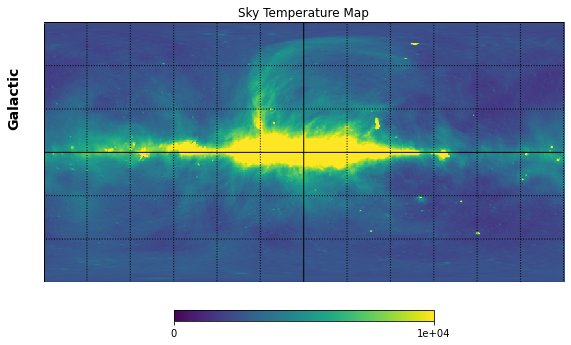

In [5]:
# At 50Mhz, the sky temperature map
hp.cartview(real_map[49], 
    title="Sky Temperature Map",
           nest=True,
           min=0,
    max=1e4, coord=["G", "G"])
hp.graticule()

In [6]:
pmlong = long
for i in range(len(long)):
    if long[i] <= 360 and long[i] >= 180:
        pmlong[i] = long[i] - 360

In [33]:
# Generate 2D Gaussian Beam Cube plane
freq = np.array(range(10,101))
x0 = 0
y0 = 0
sigx = 39
sigy = 23

lat_ = np.exp(-((lat-y0)**2/(2*(sigy**2))))
long_ = np.exp((-(long-x0)**2/(2*sigx**2)))
beam= lat_*long_* 5

In [64]:
beam.shape

(3145728,)

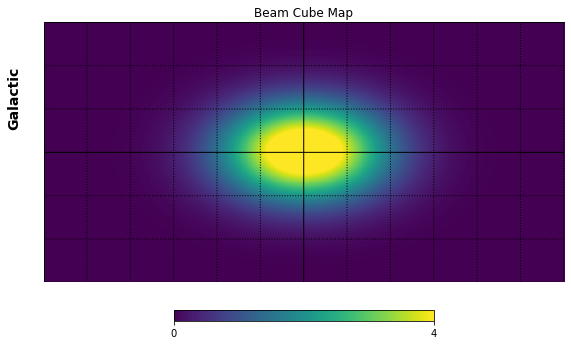

In [34]:
hp.cartview(beam, 
    title="Beam Cube Map",
           nest=True,
           min=0,
    max=4, coord=["G", "G"])
hp.graticule()

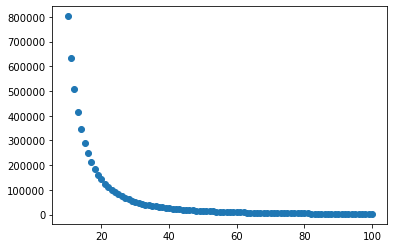

In [35]:
# Convolution to generate curve
def convolution(bc,sky):
    x = np.ones(91)
    for i in range(91):
        x[i] = np.sum(bc*sky[i])/np.sum(bc)
    return x
curve = convolution(beam,real_map)
plt.scatter(freq,curve)

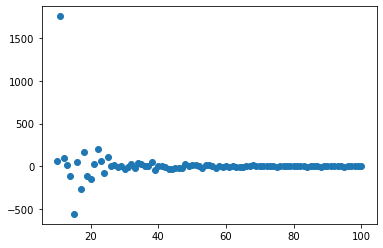

In [36]:
# Add Gaussian error to the curve
dt = 1
dnu = 1e6
sigma = curve/np.sqrt(dnu*dt)
data = np.random.normal(curve, sigma) 
noise = data - curve
plt.scatter(freq,noise)

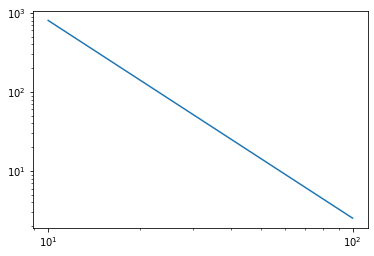

In [37]:
#Sigma
plt.loglog(freq,sigma)

In [38]:
# Define model to simulate data
def model(paras, nu):
    sigx,sigy = paras
    lat_ = np.exp(-((lat-y0)**2/(2*(sigy**2))))
    long_ = np.exp((-(long-x0)**2/(2*sigx**2)))
    beam= lat_*long_*5
    return convolution(beam,real_map)

In [39]:
# Define log-likelihood function, log-prior function, and boundary
def log_like(params, nu, data, sigma):
    m = model(params, nu)
    diff = m - data
    return -0.5 * np.sum((diff/sigma)**2)
def log_prior(params, bounds):
    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0
bounds = np.array([[38.0, 42.0], # sigx
                 [20.0,40.0]]) # sigy

In [40]:
n_particles = 4
n_dim = 2
prior_samples = np.random.uniform(low = bounds.T[0], high= bounds.T[1], size=(n_particles, n_dim))

In [41]:
# Sampler initialisation
sampler = pc.Sampler(n_particles,
                     n_dim,
                     log_likelihood=log_like,
                     log_prior=log_prior,
                     bounds=bounds,
                     log_likelihood_args=[nu, data, sigma],
                     log_prior_args=[bounds]
                    )

# Run sampler
sampler.run(prior_samples)


Iter: 0it [00:00, ?it/s]
Iter: 0it [00:00, ?it/s, beta=0, calls=4, ESS=0.95, logZ=0, accept=0.234, N=0, scale=1]
Iter: 1it [00:00, 580.13it/s, beta=4.77e-7, calls=4, ESS=0.95, logZ=0, accept=0.234, N=0, scale=1]
Iter: 1it [00:00, 423.71it/s, beta=4.77e-7, calls=4, ESS=0.95, logZ=-.143, accept=0.234, N=0, scale=1]
Iter: 1it [00:00,  1.28it/s, beta=4.77e-7, calls=8, ESS=0.95, logZ=-.143, accept=0.687, N=1, scale=1.13, corr=0.556]
Iter: 2it [00:01,  1.05it/s, beta=4.77e-7, calls=8, ESS=0.95, logZ=-.143, accept=0.687, N=1, scale=1.13, corr=0.556]
Iter: 2it [00:01,  1.05it/s, beta=3.1e-6, calls=8, ESS=0.951, logZ=-.143, accept=0.687, N=1, scale=1.13, corr=0.556]
Iter: 2it [00:01,  1.05it/s, beta=3.1e-6, calls=8, ESS=0.951, logZ=-.316, accept=0.687, N=1, scale=1.13, corr=0.556]
Iter: 2it [00:02,  1.05it/s, beta=3.1e-6, calls=12, ESS=0.951, logZ=-.316, accept=0.141, N=1, scale=1.11, corr=1]   
Iter: 2it [00:03,  1.05it/s, beta=3.1e-6, calls=16, ESS=0.951, logZ=-.316, accept=0.7, N=2, scale=1

Iter: 19it [01:25,  6.12s/it, beta=0.00965, calls=312, ESS=0.95, logZ=-4.74, accept=0.25, N=8, scale=0.955, corr=0.666]
Iter: 19it [01:26,  6.12s/it, beta=0.00965, calls=316, ESS=0.95, logZ=-4.74, accept=0.0193, N=1, scale=0.891, corr=1]  
Iter: 19it [01:27,  6.12s/it, beta=0.00965, calls=320, ESS=0.95, logZ=-4.74, accept=0.5, N=2, scale=0.944, corr=0.999]
Iter: 19it [01:28,  6.12s/it, beta=0.00965, calls=324, ESS=0.95, logZ=-4.74, accept=5.59e-5, N=3, scale=0.909, corr=0.999]
Iter: 19it [01:28,  6.12s/it, beta=0.00965, calls=328, ESS=0.95, logZ=-4.74, accept=0.00192, N=4, scale=0.882, corr=0.999]
Iter: 19it [01:29,  6.12s/it, beta=0.00965, calls=332, ESS=0.95, logZ=-4.74, accept=0.00672, N=5, scale=0.859, corr=0.999]
Iter: 19it [01:30,  6.12s/it, beta=0.00965, calls=336, ESS=0.95, logZ=-4.74, accept=0.0093, N=6, scale=0.84, corr=0.999]  
Iter: 19it [01:31,  6.12s/it, beta=0.00965, calls=340, ESS=0.95, logZ=-4.74, accept=0.0212, N=7, scale=0.824, corr=0.999]
Iter: 19it [01:32,  6.12s/i

Iter: 27it [03:12, 12.26s/it, beta=0.665, calls=740, ESS=0.95, logZ=-35.6, accept=0.0184, N=8, scale=0.355, corr=0.92]  
Iter: 27it [03:13, 12.26s/it, beta=0.665, calls=744, ESS=0.95, logZ=-35.6, accept=1.77e-5, N=9, scale=0.341, corr=0.92]
Iter: 27it [03:14, 12.26s/it, beta=0.665, calls=748, ESS=0.95, logZ=-35.6, accept=0.000549, N=10, scale=0.328, corr=0.92]
Iter: 27it [03:15, 12.26s/it, beta=0.665, calls=752, ESS=0.95, logZ=-35.6, accept=0.196, N=11, scale=0.327, corr=0.92]   
Iter: 27it [03:15, 12.26s/it, beta=0.665, calls=756, ESS=0.95, logZ=-35.6, accept=0.0739, N=12, scale=0.319, corr=0.92]
Iter: 27it [03:16, 12.26s/it, beta=0.665, calls=760, ESS=0.95, logZ=-35.6, accept=0.292, N=13, scale=0.322, corr=0.918]
Iter: 27it [03:17, 12.26s/it, beta=0.665, calls=764, ESS=0.95, logZ=-35.6, accept=0.5, N=14, scale=0.332, corr=0.908]  
Iter: 27it [03:18, 12.26s/it, beta=0.665, calls=768, ESS=0.95, logZ=-35.6, accept=0.266, N=15, scale=0.333, corr=0.887]
Iter: 27it [03:19, 12.26s/it, beta=

In [48]:
# Add extra samples
sampler.add_samples(50)
results = sampler.results


Iter: 0it [00:00, ?it/s]
Iter: 0it [00:00, ?it/s, beta=1, calls=tensor(5908), ESS=0.95, logZ=-49.5, accept=0, N=0, scale=0]
Iter: 0it [00:00, ?it/s, beta=1, calls=tensor(5912), ESS=0.95, logZ=-49.5, accept=0.00404, N=1, scale=0.199, corr=1]
Iter: 0it [00:01, ?it/s, beta=1, calls=tensor(5916), ESS=0.95, logZ=-49.5, accept=0.257, N=2, scale=0.203, corr=1]  
Iter: 0it [00:02, ?it/s, beta=1, calls=tensor(5920), ESS=0.95, logZ=-49.5, accept=0.453, N=3, scale=0.236, corr=1]
Iter: 0it [00:03, ?it/s, beta=1, calls=tensor(5924), ESS=0.95, logZ=-49.5, accept=0.0472, N=4, scale=0.213, corr=1]
Iter: 0it [00:03, ?it/s, beta=1, calls=tensor(5928), ESS=0.95, logZ=-49.5, accept=0.0258, N=5, scale=0.193, corr=1]
Iter: 0it [00:04, ?it/s, beta=1, calls=tensor(5932), ESS=0.95, logZ=-49.5, accept=0.0201, N=6, scale=0.175, corr=1]
Iter: 0it [00:05, ?it/s, beta=1, calls=tensor(5936), ESS=0.95, logZ=-49.5, accept=0.0218, N=7, scale=0.159, corr=1]
Iter: 0it [00:06, ?it/s, beta=1, calls=tensor(5940), ESS=0.95,

Iter: 6it [01:34, 15.34s/it, beta=1, calls=tensor(6400), ESS=0.95, logZ=-49.5, accept=0.345, N=3, scale=0.133, corr=1]
Iter: 6it [01:35, 15.34s/it, beta=1, calls=tensor(6404), ESS=0.95, logZ=-49.5, accept=0.315, N=4, scale=0.142, corr=1]
Iter: 6it [01:35, 15.34s/it, beta=1, calls=tensor(6408), ESS=0.95, logZ=-49.5, accept=0.5, N=5, scale=0.168, corr=0.999]
Iter: 6it [01:36, 15.34s/it, beta=1, calls=tensor(6412), ESS=0.95, logZ=-49.5, accept=0.355, N=6, scale=0.179, corr=0.999]
Iter: 6it [01:37, 15.34s/it, beta=1, calls=tensor(6416), ESS=0.95, logZ=-49.5, accept=0.519, N=7, scale=0.2, corr=0.999]  
Iter: 6it [01:38, 15.34s/it, beta=1, calls=tensor(6420), ESS=0.95, logZ=-49.5, accept=0.332, N=8, scale=0.206, corr=1]  
Iter: 6it [01:38, 15.34s/it, beta=1, calls=tensor(6424), ESS=0.95, logZ=-49.5, accept=0.25, N=9, scale=0.207, corr=0.999]
Iter: 6it [01:39, 15.34s/it, beta=1, calls=tensor(6428), ESS=0.95, logZ=-49.5, accept=0.526, N=10, scale=0.223, corr=0.999]
Iter: 6it [01:40, 15.34s/it,

Iter: 12it [03:08, 15.31s/it, beta=1, calls=tensor(6892), ESS=0.95, logZ=-49.5, accept=0.224, N=6, scale=0.188, corr=1]
Iter: 12it [03:09, 15.31s/it, beta=1, calls=tensor(6896), ESS=0.95, logZ=-49.5, accept=0.000129, N=7, scale=0.171, corr=1]
Iter: 12it [03:09, 15.31s/it, beta=1, calls=tensor(6900), ESS=0.95, logZ=-49.5, accept=0.0237, N=8, scale=0.157, corr=1]  
Iter: 12it [03:10, 15.31s/it, beta=1, calls=tensor(6904), ESS=0.95, logZ=-49.5, accept=0.222, N=9, scale=0.156, corr=1] 
Iter: 12it [03:11, 15.31s/it, beta=1, calls=tensor(6908), ESS=0.95, logZ=-49.5, accept=0.192, N=10, scale=0.154, corr=0.999]
Iter: 12it [03:12, 15.31s/it, beta=1, calls=tensor(6912), ESS=0.95, logZ=-49.5, accept=0.49, N=11, scale=0.167, corr=1]     
Iter: 12it [03:13, 15.31s/it, beta=1, calls=tensor(6916), ESS=0.95, logZ=-49.5, accept=0.146, N=12, scale=0.163, corr=1]
Iter: 12it [03:13, 15.31s/it, beta=1, calls=tensor(6920), ESS=0.95, logZ=-49.5, accept=0.0494, N=13, scale=0.155, corr=1]
Iter: 12it [03:14, 1

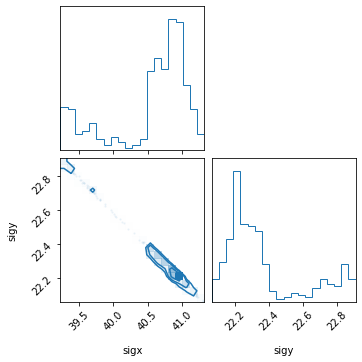

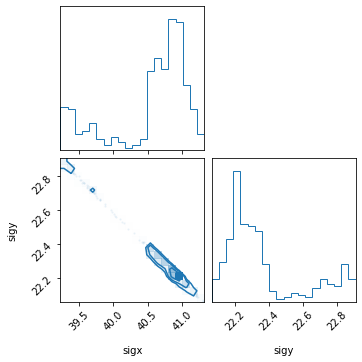

In [49]:
pc.plotting.corner(results, labels=['sigx', 'sigy'])

In [50]:
results = sampler.results

In [51]:
np.mean(results['samples'][:,0]),np.mean(results['samples'][:,1])

(40.550285, 22.360405)

In [46]:
print('Mean values = ', np.mean(results['samples'], axis=0, dtype = "float64"))
print('Standard deviation values = ', np.std(results['samples'], axis=0,dtype = "float64"))

Mean values =  [40.54146501 22.36378881]
Standard deviation values =  [0.57153842 0.23308547]


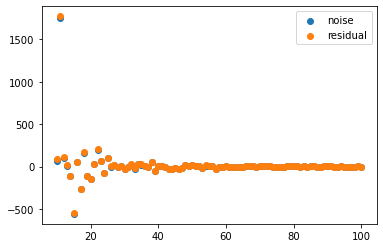

In [52]:
plt.scatter(freq, noise, label = "noise")
plt.scatter(freq, data - model([40.54146501, 22.36378881],freq), label = "residual")
plt.legend()

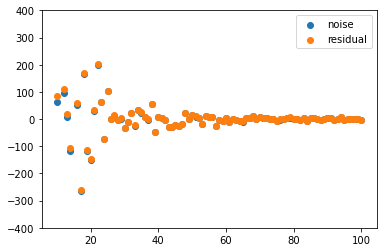

In [53]:
plt.scatter(freq, noise, label = "noise")
plt.scatter(freq, data - model([40.54146501, 22.36378881],freq), label = "residual")
plt.ylim(-400,400)
plt.legend()

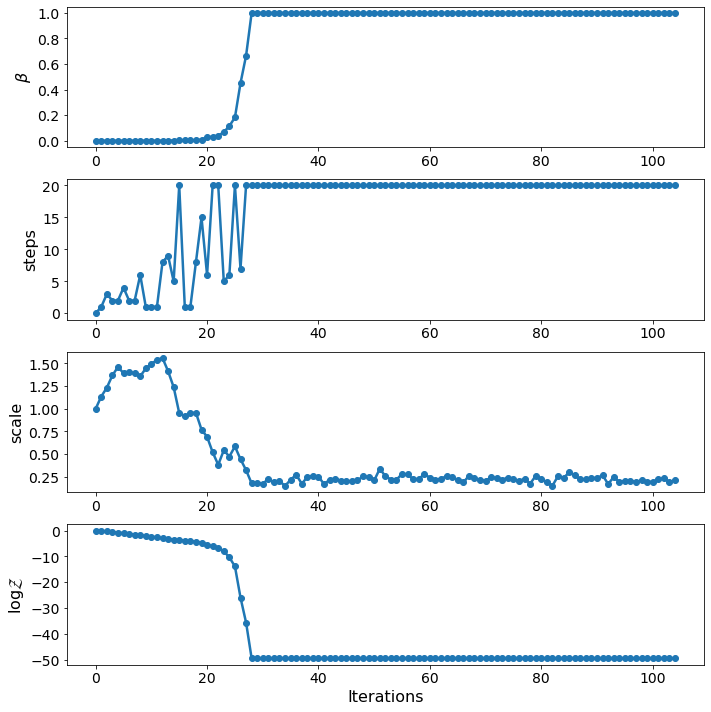

In [54]:
pc.plotting.run(results);

In [55]:
log_like([40.54146501, 22.36378881],freq,data,sigma)

-44.09884210872362

In [59]:
log_like([39,23],freq,data,sigma)

-44.063381868336315

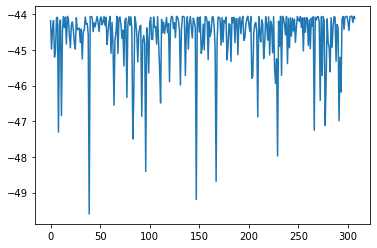

In [60]:
plt.plot(results["loglikelihood"])

In [61]:
results

{'samples': array([[40.52074 , 22.368256],
        [40.892574, 22.214241],
        [40.530376, 22.362625],
        [40.651627, 22.320408],
        [40.568306, 22.343794],
        [40.795883, 22.267036],
        [40.501945, 22.379704],
        [40.632458, 22.326744],
        [40.577568, 22.360922],
        [40.81358 , 22.24935 ],
        [40.576126, 22.346123],
        [40.594536, 22.353073],
        [40.588116, 22.33881 ],
        [40.828346, 22.247492],
        [40.604237, 22.341127],
        [40.568096, 22.350481],
        [40.651485, 22.31162 ],
        [40.80495 , 22.256237],
        [40.569035, 22.353249],
        [40.634182, 22.330233],
        [40.654373, 22.323639],
        [40.858055, 22.23134 ],
        [40.548843, 22.362251],
        [40.60105 , 22.342775],
        [40.699966, 22.304794],
        [40.812046, 22.246464],
        [40.418392, 22.41371 ],
        [40.60105 , 22.342775],
        [40.50822 , 22.371634],
        [40.926624, 22.203415],
        [40.304752, 22.464733

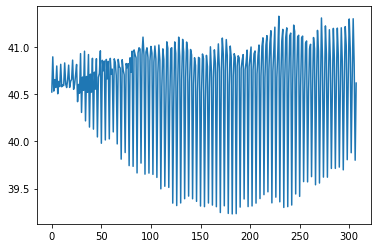

In [62]:
plt.plot(results['samples'][:,0])

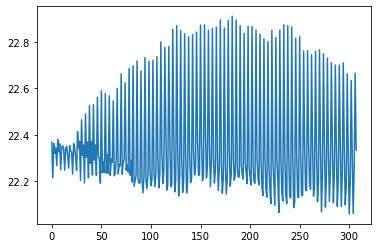

In [63]:
plt.plot(results['samples'][:,1])